In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
#訓練データ
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download = True)
#検証データ
test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12302238.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 362318.31it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2904556.52it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1668464.60it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
print("train_dataset\n", train_dataset)
print("\ntest_dataset\n", test_dataset)

train_dataset
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

test_dataset
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [7]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x): # x : 入力
        z1 = F.relu(self.fc1(x))
        z2 = F.relu(self.fc2(z1))
        y = self.fc3(z2)
        return y

In [9]:
input_size = 28*28
hidden1_size = 1024
hidden2_size = 512
output_size = 10

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("device : ", device)
model = Net(input_size, hidden1_size, hidden2_size, output_size).to(device)
print(model)

device :  cpu
Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [10]:
# 損失関数  criterion：基準
# CrossEntropyLoss：交差エントロピー誤差関数
criterion = nn.CrossEntropyLoss()

# 最適化法の指定  optimizer：最適化
# SGD：確率的勾配降下法
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
def train_model(model, train_loader, criterion, optimizer, device='cpu'):

    train_loss = 0.0  #trainの損失用の変数を定義
    num_train = 0     #学習回数の記録用の変数を定義 

    # モデルを学習モードに変換
    model.train()
    
    # データの分割数分繰り返す
    # バッチサイズ分のデータで1回パラメータを修正する
    for i, (images, labels) in enumerate(train_loader):

        # batch数をカウント
        num_train += len(labels)

        images, labels = images.view(-1, 28*28).to(device), labels.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # １推論(順伝播)
        outputs = model(images)

        # ２損失の算出
        loss = criterion(outputs, labels)

        # ３勾配計算
        loss.backward()

        # ４パラメータの更新
        optimizer.step()

        # lossを加算
        train_loss += loss.item()
    
    # lossの平均値を取る
    train_loss = train_loss / num_train

    return train_loss

In [12]:
def test_model(model, test_loader, criterion, optimizer, device='cpu'):

    test_loss = 0.0
    num_test = 0

    # modelを評価モードに変更
    model.eval()

    with torch.no_grad(): # 勾配計算の無効化
        for i, (images, labels) in enumerate(test_loader):
            num_test += len(labels)
            images, lebels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        
        # lossの平均値を取る
        test_loss = test_loss / num_test
    return test_loss

In [13]:
def learning(model, train_loader, test_loader, criterion, opimizer, num_epochs, device='cpu'):

    train_loss_list = []
    test_loss_list = []

    # epoch数分繰り返す
    for epoch in range(1, num_epochs+1, 1):

        train_loss = train_model(model, train_loader, criterion, optimizer, device=device)
        test_loss = test_model(model, test_loader, criterion, optimizer, device=device)
        
        print("epoch : {}, train_loss : {:.5f}, test_loss : {:.5f}" .format(epoch, train_loss, test_loss))

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
    
    return train_loss_list, test_loss_list

In [15]:
num_epochs = 10
train_loss_list, test_loss_list = learning(model, train_loader, test_loader, criterion, optimizer, num_epochs, device=device)

epoch : 1, train_loss : 0.00871, test_loss : 0.00843
epoch : 2, train_loss : 0.00724, test_loss : 0.00592
epoch : 3, train_loss : 0.00452, test_loss : 0.00348
epoch : 4, train_loss : 0.00294, test_loss : 0.00250
epoch : 5, train_loss : 0.00229, test_loss : 0.00209
epoch : 6, train_loss : 0.00196, test_loss : 0.00182
epoch : 7, train_loss : 0.00176, test_loss : 0.00162
epoch : 8, train_loss : 0.00162, test_loss : 0.00153
epoch : 9, train_loss : 0.00152, test_loss : 0.00144
epoch : 10, train_loss : 0.00145, test_loss : 0.00139


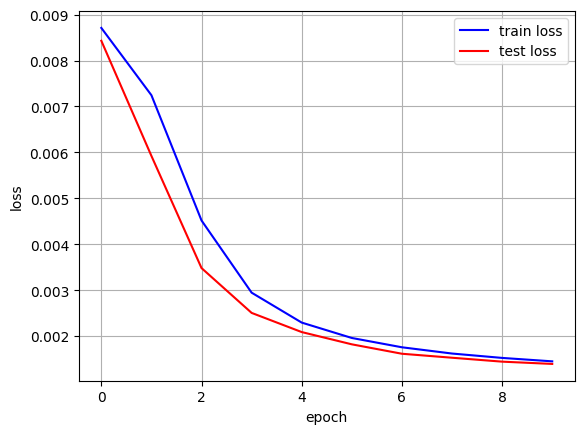

In [16]:
plt.plot(range(len(train_loss_list)), train_loss_list, c='b', label='train loss')
plt.plot(range(len(test_loss_list)), test_loss_list, c='r', label='test loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

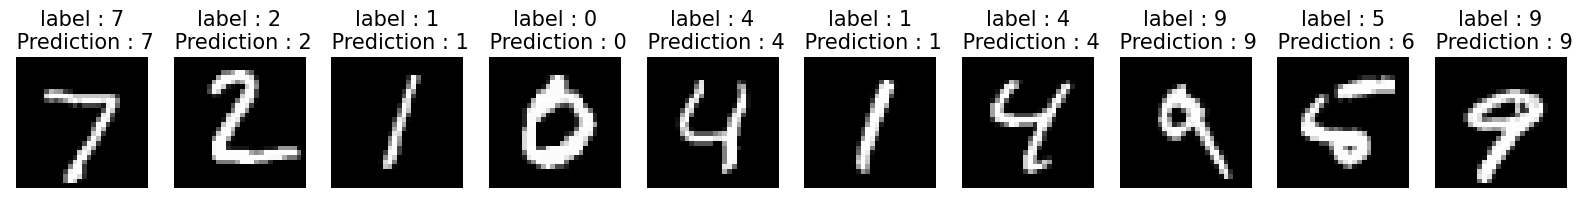

In [17]:
plt.figure(figsize=(20, 10))
for i in range(10):
    image, label = test_dataset[i]
    image = image.view(-1, 28*28).to(device)

    # 推論
    prediction_label = torch.argmax(model(image))

    ax = plt.subplot(1, 10, i+1)

    plt.imshow(image.detach().to('cpu').numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title('label : {}\n Prediction : {}'.format(label, prediction_label), fontsize=15)
plt.show()